
# Value at Risk (VaR) - 历史模拟法演示

📌 本 notebook 用于演示如何使用 Python 进行 VaR（风险价值）计算，
以等权重的债券ETF组合为例，利用历史模拟法估算 1-day 95% 的 VaR。


In [58]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## 1️⃣ 设置组合成分

- EMHY: iShares J.P. Morgan EM High Yield Bond ETF  
- HYEM: VanEck EM High Yield Bond ETF  
- EMB: iShares J.P. Morgan USD EM Bond ETF  
- PCY: Invesco EM Sovereign Debt ETF  
- EMLC: VanEck J.P. Morgan EM Local Currency Bond ETF


In [60]:
tickers = ['EMHY', 'HYEM', 'EMB', 'PCY', 'EMLC']

## 2️⃣ 下载近三年的日收盘价

In [62]:
raw = yf.download(tickers, start='2022-08-01', end='2025-07-01', progress=False)
prices = raw['Close']
prices.columns.name = None  # 移除列名多层索引，使 DataFrame 更清晰
prices.head()

,EMB,EMHY,EMLC,HYEM,PCY
Date,,,,,
2022-08-01,75.716820,28.709196,20.372955,14.689296,15.928351
2022-08-02,74.616356,28.389479,20.130419,14.515117,15.666436
2022-08-03,76.052132,28.873161,20.339502,14.730772,16.018396
2022-08-04,76.215469,28.946943,20.464958,14.714185,16.018396
2022-08-05,76.060707,28.971529,20.331137,14.722470,16.010208


## 3️⃣ 检查缺失值并处理

In [64]:
if prices.isna().sum().sum() > 0:
    print("⚠️ 存在缺失值，进行前向填充...")
    prices = prices.fillna(method='ffill')

## 4️⃣ 计算每日对数收益率

In [66]:
returns = prices.pct_change().dropna()
returns.head()

,EMB,EMHY,EMLC,HYEM,PCY
Date,,,,,
2022-08-02,-0.014534,-0.011136,-0.011905,-0.011858,-0.016443
2022-08-03,0.019242,0.017037,0.010386,0.014857,0.022466
2022-08-04,0.002148,0.002555,0.006168,-0.001126,0.000000
2022-08-05,-0.002031,0.000849,-0.006539,0.000563,-0.000511
2022-08-08,0.014807,0.015563,0.006993,0.006761,0.017382


## 5️⃣ 设置组合权重并计算组合收益

In [68]:
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
portfolio_ret = returns.dot(weights)
portfolio_ret.head()

Date
2022-08-02   -0.013175
2022-08-03    0.016798
2022-08-04    0.001949
2022-08-05   -0.001534
2022-08-08    0.012302
dtype: float64

## 6️⃣ 使用历史模拟法计算 VaR

In [70]:
confidence = 0.95
var_95 = np.percentile(portfolio_ret, (1 - confidence) * 100)

portfolio_value = 10_000_000  # 示例：1000 万美元
dollar_var = portfolio_value * var_95

print(f"\n📉 1-day 95% VaR (历史模拟法): {var_95:.4%}")
print(f"💰 名义 VaR（对应 1000 万美元组合）: ${dollar_var:,.0f}\n")


📉 1-day 95% VaR (历史模拟法): -0.8923%
💰 名义 VaR（对应 1000 万美元组合）: $-89,226



## 7️⃣ 可视化：每日收益率分布与 VaR

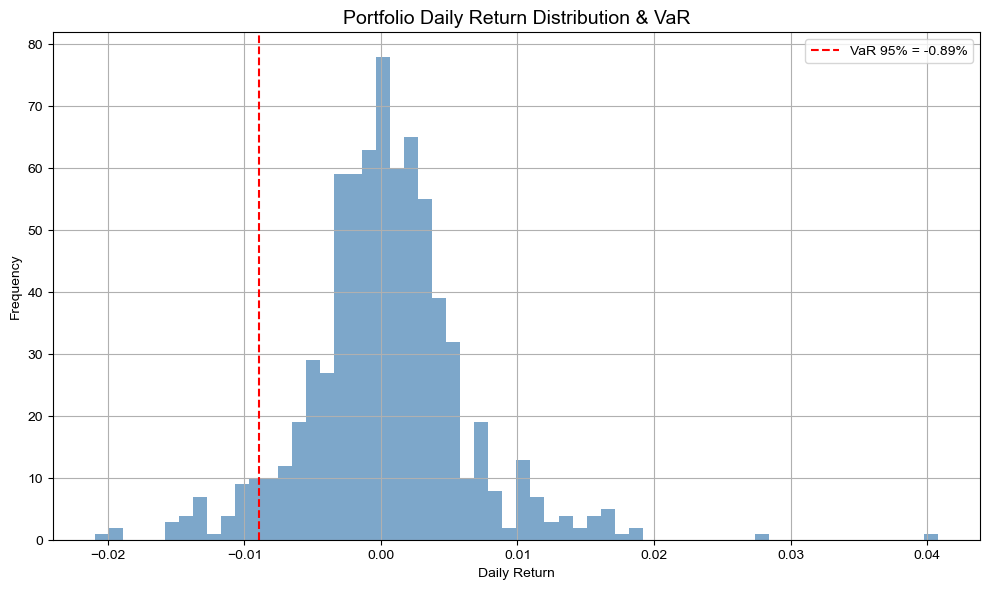

In [72]:
plt.figure(figsize=(10,6))
plt.hist(portfolio_ret, bins=60, color='steelblue', alpha=0.7)
plt.axvline(var_95, color='red', linestyle='--', label=f'VaR 95% = {var_95:.2%}')
plt.title('Portfolio Daily Return Distribution & VaR', fontsize=14)
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## ✅ CVaR（Conditional Value at Risk，条件在险价值）

CVaR 是对 VaR 的补充，关注在超过 VaR 的损失情况下的**平均损失**，可以更好地刻画极端风险情景下的潜在损失。


In [74]:
# 计算组合每日收益率
returns = prices.pct_change().dropna()

# 假设等权重组合
weights = np.array([1/len(tickers)] * len(tickers))
portfolio_returns = returns @ weights

# 计算 VaR 与 CVaR
confidence_level = 0.95
var = np.percentile(portfolio_returns, (1 - confidence_level) * 100)
cvar = portfolio_returns[portfolio_returns <= var].mean()

print(f"{int(confidence_level*100)}% VaR: {var:.4f}")
print(f"{int(confidence_level*100)}% CVaR: {cvar:.4f}")

95% VaR: -0.0089
95% CVaR: -0.0124



## ✅ VaR 贡献度分析（敏感性分析）

此模块用于分析各资产对组合总体 VaR 的边际贡献和总贡献（Component VaR），并可视化展示在热力图中，便于识别高风险来源。


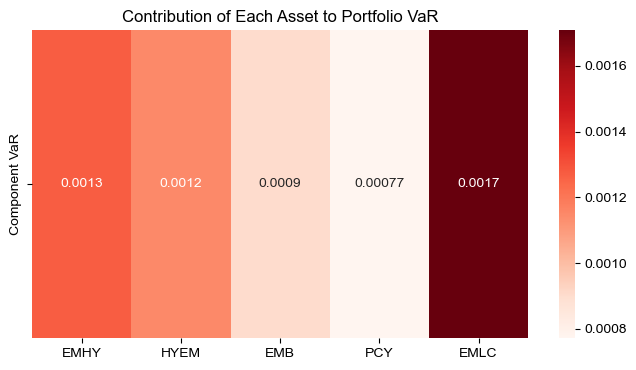

In [76]:
# 计算协方差矩阵 & 年化波动
cov_matrix = returns.cov()
portfolio_vol = np.sqrt(weights.T @ cov_matrix @ weights)

# 计算 Marginal VaR（边际 VaR）
marginal_var = cov_matrix @ weights / portfolio_vol

# 资产贡献度 (Component VaR)
component_var = weights * marginal_var

# 绘制热力图
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

# 设置英文字体（避免中文警告）
matplotlib.rcParams['font.family'] = 'Arial'  # 或 'sans-serif'

plt.figure(figsize=(8, 4))
sns.heatmap(
    component_var.values.reshape(1, -1),
    cmap="Reds",
    annot=True,
    xticklabels=tickers,
    yticklabels=["Component VaR"]
)
plt.title("Contribution of Each Asset to Portfolio VaR")
plt.show()
